#  Source and Sink Models

In this tutorial we illustrate some of the source and sink model implemented in pyC$^2$Ray. In the future, we plan to add more models, but this tutorial will give you an idea on how to implement them in your simulation, if needed.

## Source Model

The relation between the number of ionizing photons emerging from a dark matter halo of mass $M_\mathrm{halo}$ that host ionizing sources, is defined:

$$ \dot{N}_\gamma = N_\mathrm{ion}\,f_\star\,f_\mathrm{esc}\, \frac{\dot{M}_\mathrm{h}}{\mu m_\mathrm{p}} $$

Here $f_\star$, $f_\mathrm{esc}$ and $\dot{M}_\mathrm{h}$ are the stellar-to-halo relation, the photon-escaping fraction, and the halo accretion rate. While $N_\mathrm{ion}$ is the efficiency of the production of ionizing photons, $\mu$ is the molecular weight, and $m_\mathrm{p}$ is the proton mass.

For the three astrophysical quantities, we have implemented a source model that is similar to [Park+ (2019)](https://arxiv.org/abs/1809.08995) and [Sneider+ (2021)](https://arxiv.org/abs/2011.12308) approach, and we will explain it here below.

The constant parameter, $N_\mathrm{ion}$, can be found in the parameter file in the `Sources` group with the name `Nion`.

In [2]:
import pyc2ray as pc2r
import numpy as np, yaml
import matplotlib.pyplot as plt

from tqdm import tqdm

import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

As for most of the example scripts, we group the simulation paramateres in the dedicated file.

In [3]:
# read parameter file
param_file = './parameters.yml'

with open(param_file) as f:
    params = yaml.safe_load(f)

# define some random halo mass
np.random.seed(918)
mhalo = np.sort(10**np.random.uniform(low=8, high=11, size=1000))

### Stellar-to-Halo Relation
We model the stellar-to-halo ratio with a power-law function that depends on the hosting halo mass, such that:

$$ f_\star(M_\mathrm{halo})= \frac{\Omega_\mathrm{m}}{\Omega_\mathrm{b}}\, \frac{2\cdot f_{\star,0}}{\left(\frac{M_\mathrm{halo}}{M_\mathrm{p}}\right)^{\gamma_1} + \left(\frac{M_\mathrm{halo}}{M_\mathrm{p}}\right)^{\gamma_2}} \left[1 + \left(\frac{M_\mathrm{t}}{M_\mathrm{halo}} \right)^{\gamma_3} \right]^{\gamma_4}$$

This double power-law model has seven free parameters and has beeing employed for study of the Cosmic Dawn, with $\gamma_1 < 0$, $\gamma_2 < 0$, $\gamma_4 < 0$ and $\gamma_3 > 0$. However, for reionization this can be simplified to a simple power-law for $\gamma_1=\gamma_2$ and $\gamma_3=\gamma_4=0$.

In the paremeter file, you can find these free parameters in the `Sources` group. To select this model you need to choose: `fstar_kind: 'dpl'`. Moreover, you have the seven free parameters: `f0`, `Mt`, `Mp`, `g1`, `g2`, `g3` and `g4`.

Notice that one can select a mass independent model by setting $\gamma_1=\gamma_2=\gamma_3=\gamma_4=0$.

In [4]:
# load source model
source_model = pc2r.source_model.StellarToHaloRelation(model=params['Sources']['fstar_kind'], 
                                                       pars=params['Sources'], 
                                                       cosmo=cosmo)

print('Model selected in the parameter file: %s' %params['Sources']['fstar_kind'])
print('Source variable in the parameter file:\n %s' %params['Sources'])

Model selected in the parameter file: dpl
Source variable in the parameter file:
 {'fstar_kind': 'dpl', 'fgamma_hm': 30, 'fgamma_lm': 0.0, 'Nion': 2000.0, 'f0': 0.1, 'Mt': '1e8', 'Mp': '1e10', 'g1': -0.3, 'g2': -0.3, 'g3': 0, 'g4': -0.0, 'fesc_model': 'power', 'f0_esc': 0.02, 'Mp_esc': '1e10', 'al_esc': -0.25, 'accretion_model': 'EXP', 'alpha_h': 0.79, 'bursty_sfr': 'no', 'beta1': 0.1, 'beta2': 1.5, 'tB0': 200.0, 'tQ_frac': 1.6, 'z0': 30.0, 't_rnd': 0}


In [5]:
# load source model
fstar_pars = {'Nion': 4., 'f0': 0.1, 'Mt': 1e8, 'Mp': 1e10, 'g1': -0.3, 'g2': -0.2, 'g3': 0.1, 'g4': -0.2, 'alpha_h': 0.79}
source_model = pc2r.source_model.StellarToHaloRelation(model='dpl', pars=fstar_pars, cosmo=cosmo)

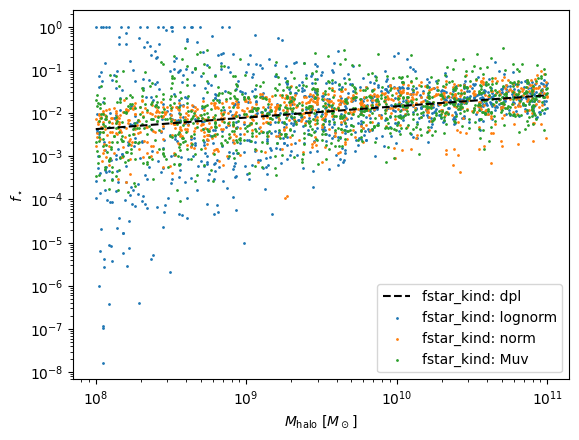

(None, None)

<Figure size 640x480 with 0 Axes>

In [6]:
fstar1 = source_model.deterministic(Mhalo=mhalo)
fstar2 = source_model.stochastic_lognormal(Mhalo=mhalo)
fstar3 = source_model.stochastic_Gaussian(Mhalo=mhalo, sigma=[1.]*mhalo.size)
fstar4 = source_model.fstar_from_Muv(Mhalo=mhalo, z=7.305)

plt.loglog(mhalo, fstar1, color='black', ls='--', label='fstar_kind: dpl')
plt.scatter(mhalo, fstar2, s=1, color='tab:blue', label='fstar_kind: lognorm')
plt.scatter(mhalo, fstar3, s=1, color='tab:orange', label='fstar_kind: norm')
plt.scatter(mhalo, fstar4, s=1, color='tab:green', label='fstar_kind: Muv')
plt.legend()
plt.xlabel(r'$M_\mathrm{halo}$ [$M_\odot$]'), plt.ylabel(r'$f_\star$')
plt.show(), plt.clf()

### Escaping Fraction Model
We model the stellar-to-halo ratio with a power-law function that depends on the hosting halo mass, such that:

$$ f_\mathrm{esc}(M_\mathrm{halo})= f_\mathrm{esc,0}\, \left(\frac{M_\mathrm{halo}}{M_\mathrm{p,esc}} \right)^{\alpha_\mathrm{esc}} $$

This power-law model has three free parameters, $f_\mathrm{esc,0}$, $M_\mathrm{p,esc}$ and $\alpha_\mathrm{esc} > 0$. 

In the paremeter file, you can find these free parameters in the `Sources` group. To select this model you need to choose: `fesc_model: 'power'`. Moreover, you have the free parameters: `f0_esc`, `Mp_esc` and `al_esc`.

Notice that one can select a mass independent model by setting $\alpha_\mathrm{esc}=0$.

In [7]:
fesc_pars = {'f0_esc': 0.02, 'Mp_esc': 1e10, 'al_esc': 0.5}
fesc_model = pc2r.source_model.EscapeFraction(model='power', pars=fesc_pars)

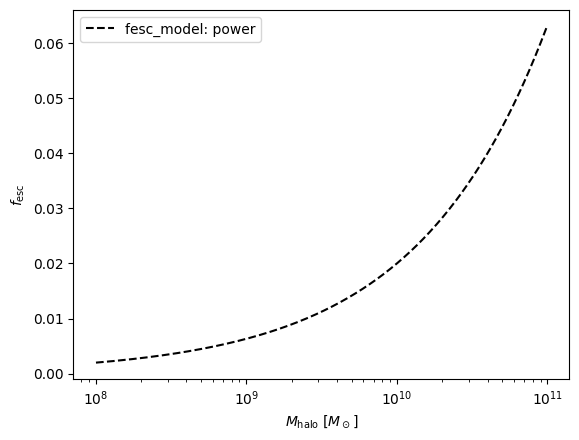

(None, None)

<Figure size 640x480 with 0 Axes>

In [8]:
fesc1 = fesc_model.deterministic(Mhalo=mhalo)
plt.semilogx(mhalo, fesc1, color='black', ls='--', label='fesc_model: power')
plt.legend()
plt.xlabel(r'$M_\mathrm{halo}$ [$M_\odot$]'), plt.ylabel(r'$f_\mathrm{esc}$')
plt.show(), plt.clf()

###  Halo Accretion Rate
We model the halo accretion rate with a time scale variable, $t_\mathrm{s}$, representing the source lifetime in our model.

$$ \dot{M}_\mathrm{h}(z) = \frac{M_\mathrm{halo}(z)}{t_\mathrm{s}} = \frac{M_\mathrm{halo}(z)}{\left[ \alpha_\mathrm{h}(1+z)\,H(z) \right]^{-1}} $$

where $\alpha_\mathrm{h}$ is a free parameter and $H(z)$ is the Friedmann equation.

This analytical model assumes that the halos grow exponentially with the follwing relation:

$$ M_\mathrm{halo}(z) = M_\mathrm{halo,0}\,e^{-\alpha_\mathrm{h}(z-z_0)} $$

Where at $z_0$ the halo has initial mass of $M_\mathrm{halo,0}$.

In the paremeter file, you can find the free parameter in the `Sources` group. To select this model you need to choose: `acretion_model: 'EXP'`. Moreover, you have the free parameters: `alpha_h`.

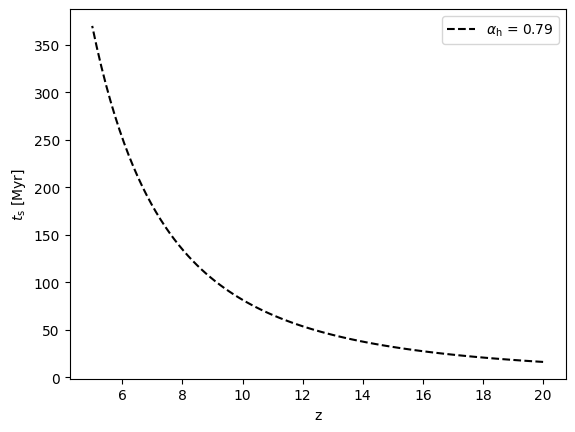

(None, None)

<Figure size 640x480 with 0 Axes>

In [9]:
# get some redshifts
redshifts = np.linspace(20, 5, 100)

# calculate the time scale variable
t_s = (source_model.source_liftime(z=redshifts) * u.s).to('Myr')

plt.plot(redshifts, t_s, 'k--', label=r'$\alpha_\mathrm{h}$ = %.2f' %source_model.alph_h)
plt.xlabel('z'), plt.ylabel(r'$t_\mathrm{s}$ [Myr]')
plt.legend()
plt.show(), plt.clf()

### Bursty Star Formation Model

We have an analytical model for a bursty star-formation rate is defined with a bursty time-scale, $t_\mathrm{B}$.

$$ t_\mathrm{B}(M_h,t) = t_\mathrm{B,0}\cdot\left(\frac{M_h}{10^{10}\,M_\odot}\right)^{\beta_1}\cdot\left[H(t)(t-t_0)\right]^{\beta_2} $$

where $t_\mathrm{B,0}$, $\beta_1$, $\beta_2$ and $t_0$ are free parameters.

The length of the quiessence time is define by a factor parameters:

$$ t_\mathrm{Q} = t_\mathrm{Q,frac} \cdot t_\mathrm{B}$$

In the paremeter file, you can find the free parameter in the `Sources` group. To select this model you need to choose: `acretion_model: 'instant'`. Moreover, you have the free parameters: `beta1`, `beta2`, `tB0`, `z0` and `tQ_frac`.

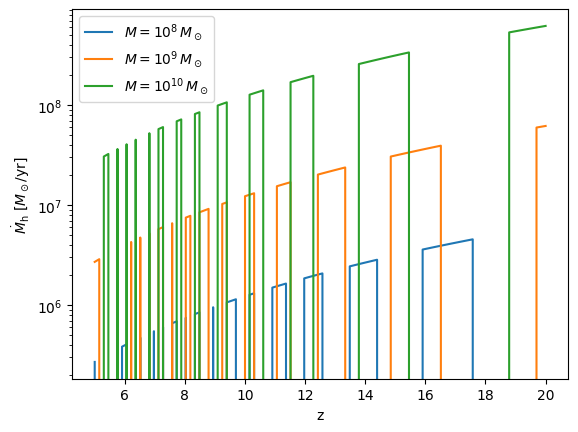

In [10]:
bursty_pars = {'beta1': 0.1, 'beta2': 0.2, 'tB0': 300., 'tQ_frac': 0.95, 'z0': 30., 't_rnd': 0}
bursty = pc2r.source_model.BurstySFR(model='instant', pars=bursty_pars, alpha_h=0.79, cosmo=cosmo)

for m in [1e8, 1e9, 1e10]:
    # bursty SFR mask
    bh1 = bursty.instant_burst_or_quiescent_galaxies(mass=m, z=redshifts)
    
    # accreation rate (here in Myr)
    dotM = m/t_s.value
    
    plt.semilogy(redshifts, dotM*bh1, label=r'$M = 10^{%d}\,M_\odot$' %np.log10(m))

plt.ylabel(r'$\dot{M}_\mathrm{h}$ [$M_\odot/\mathrm{yr}$]'), plt.xlabel('z')
plt.legend()

# Sink Model

Here, below we show the sink models implemented in pyC$^2$Ray.

## Clumping Factor
We define the gas clumping factor based on the cell-wise averaged quantities of the simulated intergalactic (IGM) density field:

$$ \mathcal{C} = \frac{\left< n^2_\mathrm{IGM}\right>}{\left< n_\mathrm{IGM}\right>^2} $$

For homogeneous density, this quantity is close to unity, but if matter distribution within the volume can a few order of magnitude larger.

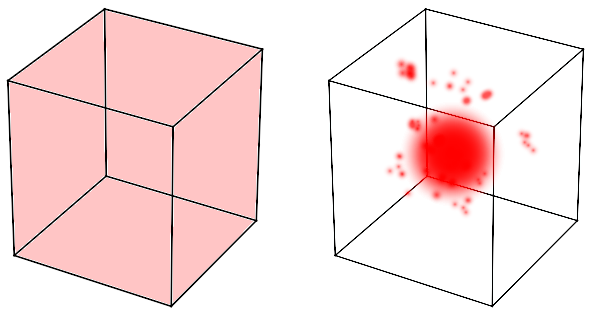

In [11]:
from IPython.display import Image, display
display(Image('example_clump.png'))

In the figure here above, we illustrate how a volume (a voxel in a simulation) can have the same density, $\left<n_\mathrm{IGM}\right>$, but different clumping factor. In the left panel, an homogeneous field has $\mathcal{C} = 1$, while for an highly inhomogeneous field (right panel) the clumping is, $\mathcal{C} \geq 1$.

Here, we look at the clumping model implemented in pyC$^2$Ray that can be selected in the parameter file, `parameters.yml`, within the `Sinks` group and the variable `clumping_model`. Here, we refer the reader to [Bianco et al. (2021)](https://arxiv.org/abs/2101.01712) and [Mao et al. (2019)](https://arxiv.org/abs/1906.02476) for a review on the sub-grid clumping models illustrated here below.

The standard approach consider a __constant clumping factor__ which is redshift, $z$ and density-independent $\delta_\mathrm{IGM}$. This can be selected in the parameter file by: `clumping_model: 'constant'` and is defined:

$$ \mathcal{C}(z, \delta_\mathrm{IGM}) \equiv c^{ste}$$

The clumping value can be changed in the parameter file. The standard setup ignores the contribution by the sub-grid clumping inhomogeneity and set the value to one, `clumping: 1.0`.

In [12]:
params['Sinks']['clumping_model'] = 'constant'

print('Clumping model:', params['Sinks']['clumping_model'], 'with constant clumping factor:', params['Sinks']['clumping'])
sm = pc2r.sinks_model.SinksPhysics(params=params, N=params['Grid']['meshsize'])

const_clump = sm.calculate_clumping

# look at the min and max
print(const_clump.min(), const_clump.max(), const_clump.shape)

Clumping model: constant with constant clumping factor: 1.0
1.0 1.0 (256, 256, 256)


The __bias homogeneous clumping__ (BHC) model considers a redshit evolving clumping factor that is independent of the sub-grid inhomogeneities. The model is defined as:

$$ \mathcal{C}(z) = C_0\cdot e^{c_1\cdot z+c_2\cdot z^2} + 1$$

Here, the parameters $C_0$, $c_1$ and $c_2$ are free parameters that have been fit to a high-resolution N-body simulation. These tables of fitting parameters can be found in `pyC2R|ay/pyc2ray/tables/clumping/`.

This can be selected in the parameter file by: `clumping_model: 'redshift'` in the `Sinks` group.

In [14]:
# modify the parameters file for a different clumping model
params['Sinks']['clumping_model'] = 'redshift'
print('Clumping model:', params['Sinks']['clumping_model'])

sm = pc2r.sinks_model.SinksPhysics(params=params, N=params['Grid']['meshsize'])

# select a redshift
z = 10.0
homogeneous_clump = sm.calculate_clumping(z=z)

# look at the min and max
print(homogeneous_clump.min(), homogeneous_clump.max(), homogeneous_clump.shape)

Clumping model: redshift
9.385467951445468 9.385467951445468 (256, 256, 256)


The __ihomogeneous clumping__ (IC) model fit the clumping factor based on the simulated sub-grid density inhomogeneity. Therefore, the model read the density field an calculate the integalactic medium (IGM) overdensity, $1+\delta_\mathrm{IGM}$. The model is then defined as:

$$ \mathcal{C}(z, \delta_\mathrm{IGM}) = a\cdot (1+\delta_\mathrm{IGM})^2 + b \cdot (1+\delta_\mathrm{IGM}) + c$$

Here, the parameters $a$, $b$ and $c$ are free parameters and the fitting parameters can be found in `pyC2Ray/pyc2ray/tables/clumping/`.

This can be selected in the parameter file by: `clumping_model: 'density'` in the `Sinks` group.

In [15]:
N = params['Grid']['meshsize']

# modify the parameters file for a different clumping model
params['Sinks']['clumping_model'] = 'density'
print('Clumping model:', params['Sinks']['clumping_model'])

sm = pc2r.sinks_model.SinksPhysics(params=params, N=N)

# select a redshift and create a mock density field
z = 10.0
overd = 1.0 + np.random.normal(loc=0, scale=0.1, size=(N, N, N))
ndens = cosmo.critical_density(z).cgs.value * overd

inhomogeneous_clump = sm.calculate_clumping(ndens=ndens, z=z)

# look at the min and max
print(inhomogeneous_clump.min(), inhomogeneous_clump.max(), inhomogeneous_clump.shape)

Clumping model: density
15.082506863292846 32.797772946000556 (256, 256, 256)


All the model return a 3D grid with the same mesh-size, and spatial resolution, of the density field. A series of tables, with the corresponding fitting parameters, can be found in `pyC2Ray/pyc2ray/tables/clumping/`. 

To date, we have tables for different spatial resolution, i.e.: $\Delta r = 2.094$, $2.024$, $1.518$, $1.162$ and $1.012\,\rm Mpc$ for a redshift range between $z\in[45,\,7.3]$. In future work, we plan to increase the number of tables.

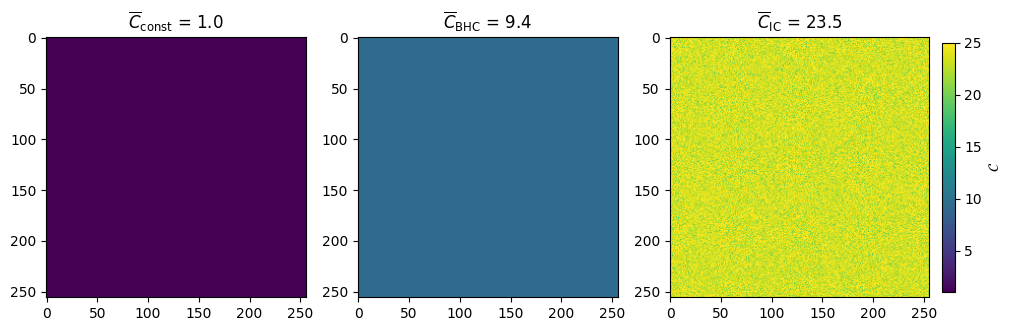

In [16]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=1, ncols=3, constrained_layout=True)

axs[0].set_title('$\overline{C}_\mathrm{const}$ = %.1f' %const_clump.mean())
im = axs[0].imshow(const_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)

axs[1].set_title('$\overline{C}_\mathrm{BHC}$ = %.1f' %homogeneous_clump.mean())
im = axs[1].imshow(homogeneous_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)

axs[2].set_title('$\overline{C}_\mathrm{IC}$ = %.1f' %inhomogeneous_clump.mean())
im = axs[2].imshow(inhomogeneous_clump[...,N//2], cmap='viridis', vmin=1, vmax=25)
plt.colorbar(im, ax=axs[2], label=r'$\mathcal{C}$', pad=0.02, fraction=0.048)

In [17]:
# TODO: mean-free path